# Data Cleaning and Preprocessing Notebook

This Jupyter Notebook provides a step-by-step approach to cleaning and preprocessing a dataset containing various fuel and ignition-related parameters. The main goal is to prepare the data for further analysis or modeling by ensuring consistency, removing noise, and addressing common data quality issues.

July 28, 2025

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import re
import shap # For SHAP method execution
from sklearn.ensemble import RandomForestRegressor # For construction of surrogate model
from sklearn.model_selection import train_test_split # For training and testing of the model
from sklearn.preprocessing import LabelEncoder # For encoding categorical features
from pprint import pprint # Import pprint for pretty printing


In [139]:
#Charge or df.
full_df = pd.read_csv("working_df_v3.csv")

In [140]:
len(full_df)

14018

<span style="color: blue;">0. Know our data OK </span> 

In [141]:
# Let's look at the columns
print('\n'.join(full_df.columns))
# There are 47 columns

Unnamed: 0
plan_id
plan_uuid
plan_name
objectives
is_public
acres
ensemble_id
ensemble_uuid
ens_name
ens_status
is_single_run
qf_parameters
fuel_id
fuel_uuid
fuel_parameters
fuel_status
fuel_viz
fuel_viz_running
parent_id
fuel_ignition_id
fuel_blackline_removed
ignition_id
ignition_uuid
ignition_parameters
ignition_pattern
ignition_fuel_removal_area
ignition_dat
ignition_viz
ignition_viz_running
plan_feature_id
unit_feature_id
unit_feature_uuid
unit_id
unit_feature_properties
unit_feature_geom
unit_feature_geom_wkt
unit_uuid
unit_user_id
unit_name
unit_uniform
unit_filename
unit_uploaded_time
unit_is_public
run_id
run_uuid
run_ignition_id
run_parameters
run_status
percent_done
run_viz
metrics
run_viz_running
status_updated_time
execution_try


In [142]:
# Impresión del nombre de las unidades con el número de veces que hay en "full_df"
for unit, count in full_df["unit_name"].value_counts().items():
    print(f"{unit}: {count}")

Independence Lake: 1498
upload from QF GUI test1: 1230
NLFTD Treatment Units North of Hwy 431: 864
mcguire prescribed: 363
PML Oct 15 Unit 9: 353
sedgwick separated: 343
Hone Quarry Subsection: 341
new_mixedcon_area.zip: 317
PML Oct 15 Unit 11: 267
Test: 264
Blodgett: 262
euc: 250
sedgwick: 243
kern-units.geojson: 232
Kern County: 195
auburn2: 176
eglin-rect1-wgs: 171
Willamette Valley - whale pasture south: 167
Saddle_mountain_thinning_units: 162
ft-stewart: 160
st-group-units: 159
LA Hill: 147
Osceola NF florida: 144
NE hills low fuel: 144
Jennifer 5: 144
shaver lake: 138
Big Trees Leticia: 135
Sedgwick: 132
Pacific union college: 129
Collins_units: 111
JBLM Burn Units: 108
Yosemite: 102
Yuba: 87
sc-inspo-units: 78
St. Mary: 78
Pacific Union College: 78
la jolla subsection: 75
slef serdp 2019 large: 75
PML Oct 15 Unit 17: 75
rx510: 72
OK flat: 72
Koyukon 1: 72
Kern-v2: 72
Winton Schaad VMP: 72
Osceloa_NF_FL: 72
Winton Schaads: 72
New Hogan Oct 15: 72
partial D13-5: 72
Unit G - MSJ: 7

In [143]:
# Keep only the columns that we need, based in Ismael and Pedro's analysis.
columns_to_keep = ['fuel_id',
                   'unit_feature_id',
                   'run_parameters',
                   'ignition_parameters',
                   'ignition_pattern',
                   'metrics', ]
sub_df = full_df[columns_to_keep]

In [144]:
# Let's access the first element (index 0) of specific columns in sub_df.
# Create a dictionary to hold the collected data for better organization and display.
# Each key in the dictionary corresponds to a column name, and its value is the data
# retrieved from the first row of that column.
display_data = {
    'run_parameters': sub_df['run_parameters'][0],
    'ignition_parameters': sub_df['ignition_parameters'][0],
    'ignition_pattern': sub_df['ignition_pattern'][0],
    'metrics': sub_df['metrics'][0]
}
pprint(display_data, width=200, depth=None)

{'ignition_parameters': "{'crew': [{'velocity': 2, 'gap_length': 4.0, 'dash_length': 4.0}, {'velocity': 2, 'gap_length': 4.0, 'dash_length': 4.0}, {'velocity': 2, 'gap_length': 4.0, 'dash_length': "
                        "4.0}], 'side': 'right', 'depth': 10, 'buffer': 200, 'offset': 10, 'replace': True, 'spacing': 10, 'blackline': 10, 'clockwise': True, 'heat_depth': 10, 'control_line': 4, "
                        "'pattern_type': 'strip', 'firing_direction': 90}",
 'ignition_pattern': "{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiLineString', 'coordinates': [[[-82.36619532910359, 30.70976140231043], "
                     '[-82.36619583774286, 30.70979748653289]], [[-82.36619634638303, 30.709833570755148], [-82.36619685502414, 30.7098696549772]], [[-82.36619736366616, 30.70990573919904], '
                     '[-82.3661978723091, 30.709941823420664]], [[-82.36619838095294, 30.70997790764209], [-82.36619888959771, 30.710013991863303]], [

<span style="color: blue;">1. Removing Duplicate Data OK </span>

In [145]:
def remove_duplicates(df):
    """
    Detects and removes duplicate rows from the DataFrame based on fuel_id

    Args:
        df (pd.DataFrame): DataFrame to clean.

    Returns:
        pd.DataFrame: DataFrame without duplicate rows.
    """
    num_dups = df.duplicated().sum()
    print(f"Duplicate rows found: {num_dups}")

    if num_dups > 0:
        df = df.drop_duplicates().reset_index(drop=True)
        print(f"Duplicates removed. New DataFrame shape: {df.shape}")
    else:
        print("No duplicates found.")
    
    return df

remove_duplicates(sub_df)
len(sub_df)

Duplicate rows found: 0
No duplicates found.


14018

<span style="color: blue;">2. Convert Data Type OK</span>

Now I will create our working df. This needs a few tricks. 

### a. Cleaning the `ignition_parameters`,`ignition_pattern`, `metrics` and `run_parameters` columns

In [146]:
# We need to format the ignition parameters column

# Helper function 
def clean_json_string(json_str):
    """
    Cleans a string to make it a valid JSON string by handling single quotes, 
    Python booleans/None, and trailing commas.
    """
    if not isinstance(json_str, str):
        return None  # Skip non-string entries
    json_str = json_str.replace("'", '"')
    json_str = re.sub(r'\bTrue\b', 'true', json_str)
    json_str = re.sub(r'\bFalse\b', 'false', json_str)
    json_str = re.sub(r'\bNone\b', 'null', json_str)  
    json_str = re.sub(r',(\s*[\]}])', r'\1', json_str)
    return json_str

# str -> JSON
# Apply the cleaning function and parse JSON
def parse_json_column(df, column):
    """
    Parses a DataFrame column containing JSON-like strings into actual JSON objects.
    It cleans the strings first using clean_json_string and handles parsing errors.

    Args:
        df (pd.DataFrame): The DataFrame containing the column to parse.
        column (str): The name of the column containing JSON-like strings.

    Returns:
        list: A list of indices where JSON parsing failed.
    """
    cleaned_data = []
    error_indexes = []
    
    # Iterate through each item in the specified column along with its index
    for idx, item in df[column].items():  
        # Clean the string using the helper function
        cleaned_str = clean_json_string(item)
        
        try:
            # Attempt to parse the cleaned string into a JSON object
            # If cleaned_str is None or empty after cleaning, append None
            parsed_json = json.loads(cleaned_str) if cleaned_str else None
            cleaned_data.append(parsed_json)
        except json.JSONDecodeError:
            # If parsing fails, record the index and append None to cleaned_data
            error_indexes.append(idx)  # Save the index for rows that failed to parse
            cleaned_data.append(None)  # Mark failed parses as None
            
    # Add the parsed data (or None for failures) as a new column in the DataFrame
    # The new column will be named 'parsed_originalColumnName'
    df.loc[:,f'parsed_{column}'] = cleaned_data
    
    # Return the list of indices where parsing errors occurred
    return error_indexes

# GENERAL FUNCTION TO CLEAN NULL VALUES FROM KEY COLUMNS
def drop_null_rows(df, column_names):
    """
    Drops rows from the DataFrame `df` where the columns in `column_names` have null values.
    
    Args:
        df (pd.DataFrame): The DataFrame to clean.
        column_names (list): List of column names to check.
    
    Returns:
        pd.DataFrame: A new DataFrame without rows that have null values in the specified columns.
    """
    for col in column_names:
        null_indexes = df[df[col].isnull()].index.tolist()
        if null_indexes:
            print(f"Dropping {len(null_indexes)} rows due to null values in '{col}'")
            df = df.drop(index=null_indexes).reset_index(drop=True)
    return df

In [147]:
# This list specifies the names of the DataFrame columns that are expected to contain
# JSON-like strings and need to be converted into proper JSON
json_columns = ['run_parameters', 'ignition_parameters', 'ignition_pattern', 'metrics']

# Loop to clean and parse JSON columns
for col in json_columns:
    print(f"Processing column: {col}")
    # Call the 'parse_json_column' function to clean and parse the JSON strings
    # in the current column ('col') of the DataFrame ('sub_df').
    # This function adds a new column (e.g., 'parsed_run_parameters') to 'sub_df'
    # with the converted JSON objects, and returns a list of indices where parsing failed.
    error_indices = parse_json_column(sub_df, col)
    
    # Print the number of rows where JSON parsing failed for the current column.
    print(f"Parsing errors in {col}: {len(error_indices)}")

# Remove rows with null values in the parsed columns
# Create a new list containing the names of the newly created parsed columns.
# These names follow the pattern 'parsed_originalcolumnname'.
parsed_columns = [f"parsed_{col}" for col in json_columns]

# Use the 'drop_null_rows' function to remove any rows from 'sub_df'
# where there are null values (including those resulting from failed JSON parsing)
# in any of the newly created 'parsed_' columns.
# This ensures that all key parsed columns have valid data.
sub_df = drop_null_rows(sub_df, parsed_columns)

Processing column: run_parameters


/var/folders/1r/xclpw1ds2hsgwqqdgs57snzw0000gn/T/ipykernel_69464/1189511972.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'parsed_{column}'] = cleaned_data
/var/folders/1r/xclpw1ds2hsgwqqdgs57snzw0000gn/T/ipykernel_69464/1189511972.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'parsed_{column}'] = cleaned_data


Parsing errors in run_parameters: 0
Processing column: ignition_parameters
Parsing errors in ignition_parameters: 0
Processing column: ignition_pattern


/var/folders/1r/xclpw1ds2hsgwqqdgs57snzw0000gn/T/ipykernel_69464/1189511972.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'parsed_{column}'] = cleaned_data


Parsing errors in ignition_pattern: 0
Processing column: metrics


/var/folders/1r/xclpw1ds2hsgwqqdgs57snzw0000gn/T/ipykernel_69464/1189511972.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,f'parsed_{column}'] = cleaned_data


Parsing errors in metrics: 0
Dropping 2547 rows due to null values in 'parsed_ignition_parameters'
Dropping 3 rows due to null values in 'parsed_metrics'


In [148]:
len(sub_df)

11468

<span style="color: blue;">3. Handle Missing Values OK</span>

In [149]:
# Function to check if imputation is necessary before dropping rows.
def count_rows_with_any_null(df, columns):
    """
    Counts how many rows have at least one null value in the specified columns.

    Args:
        df (pd.DataFrame): Your DataFrame.
        columns (list): List of key columns to check.

    Returns:
        int: Number of rows with at least one null in those columns.
    """
    # Create a boolean mask:
    # 1. df[columns].isnull() creates a DataFrame of booleans, True where null, False otherwise,
    #    only for the specified 'columns'.
    # 2. .any(axis=1) checks if ANY value in each row of this boolean DataFrame is True (i.e., if there's any null in that row).
    #    This results in a Series of True/False, where True means the row has at least one null in the specified columns.
    null_mask = df[columns].isnull().any(axis=1)
    
    # Sum the boolean mask: True counts as 1, False as 0. This gives the total count of rows
    # that have at least one null in the specified columns.
    count = null_mask.sum()
    
    # Print a user-friendly message showing the count of rows with nulls
    # and the total number of rows in the DataFrame.
    print(f"Rows with at least one null in {columns}: {count} out of {len(df)} total.")
    
    # Return the calculated count.
    return count

# Define the list of parsed column names.
# This list is created by prefixing 'parsed_' to the original JSON column names,
parsed_columns = [f"parsed_{col}" for col in ['run_parameters', 'ignition_parameters', 'ignition_pattern', 'metrics']]

# This executes the function to report the number of rows in 'sub_df'
# that contain at least one null value across any of the 'parsed_columns'.
count_rows_with_any_null(sub_df, parsed_columns)

Rows with at least one null in ['parsed_run_parameters', 'parsed_ignition_parameters', 'parsed_ignition_pattern', 'parsed_metrics']: 0 out of 11468 total.


0

In [150]:
'''
# As our previous steps return 0, there is not need to call this cell.
# Remove rows with null values in the parsed columns
# This step aims to clean the DataFrame by eliminating rows where critical parsed data is missing.

# First, create a list of the names of the newly generated columns.
# These are the columns that resulted from the JSON parsing process (e.g., 'parsed_run_parameters', 'parsed_metrics').
# It's assumed that 'json_columns' is a pre-defined list containing the original column names.
parsed_columns = [f"parsed_{col}" for col in json_columns]

# Now, use the 'drop_null_rows' function to perform the actual cleaning.
# This function iterates through each column in 'parsed_columns'.
# For every column, it identifies rows containing any null values (e.g., from failed JSON parsing)
# and removes those entire rows from the DataFrame.
# The result is a 'sub_df' that only contains rows where all the specified 'parsed_columns' have valid, non-null data.
#///sub_df = drop_null_rows(sub_df, parsed_columns)

# Finally, display the number of rows remaining in the DataFrame after the cleaning process.
# This gives a quick overview of how many rows were kept and how many were dropped due to nulls.
len(sub_df)
# As our previous steps return 0, there is not need to call this cell.'''

'\n# As our previous steps return 0, there is not need to call this cell.\n# Remove rows with null values in the parsed columns\n# This step aims to clean the DataFrame by eliminating rows where critical parsed data is missing.\n\n# First, create a list of the names of the newly generated columns.\n# These are the columns that resulted from the JSON parsing process (e.g., \'parsed_run_parameters\', \'parsed_metrics\').\n# It\'s assumed that \'json_columns\' is a pre-defined list containing the original column names.\nparsed_columns = [f"parsed_{col}" for col in json_columns]\n\n# Now, use the \'drop_null_rows\' function to perform the actual cleaning.\n# This function iterates through each column in \'parsed_columns\'.\n# For every column, it identifies rows containing any null values (e.g., from failed JSON parsing)\n# and removes those entire rows from the DataFrame.\n# The result is a \'sub_df\' that only contains rows where all the specified \'parsed_columns\' have valid, non-null 

In [151]:
sub_df

,fuel_id,unit_feature_id,run_parameters,ignition_parameters,ignition_pattern,metrics,parsed_run_parameters,parsed_ignition_parameters,parsed_ignition_pattern,parsed_metrics
0,54,41,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 2, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...","{'consumption_all_levels': [0.968562662601471,...","{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 2, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...","{'consumption_all_levels': [0.968562662601471,..."
1,54,41,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 2, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9693431258201599...,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 2, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9693431258201599...
2,54,41,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 2, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9666581153869629...,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 2, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9666581153869629...
3,52,40,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 0, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9812050461769104...,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 0, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9812050461769104...
4,52,40,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 0, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9814903140068054...,"{'dz': None, 'seed': -1, 'topo': {'topo_calcs'...","{'crew': [{'velocity': 0, 'gap_length': 4.0, '...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.9814903140068054...
...,...,...,...,...,...,...,...,...,...,...
11463,3017,2829,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7167190313339233...,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7167190313339233...
11464,3017,2829,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7439647316932678...,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7439647316932678...
11465,3019,3648,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7066090106964111...,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7066090106964111...
11466,3019,3648,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all_levels': [0.7030316591262817...,"{'dz': None, 'seed': 222, 'topo': {'topo_calcs...","{'crew': [{'velocity': 0.8940545373267769, 'ga...","{'type': 'FeatureCollection', 'features': [{'t...",{'consumption_all

<span style="color: blue;">4. Eliminate Unnecessary Data OK</span></span>


In [152]:
# Here I define the groups, there are 19
new_df = {'fuel_id':[],
          'unit_feature_id':[],
          'surface_consumed':[], 
          'midstory_consumed':[], 
          'canopy_consumed':[], 
          'fdfm':[], 
          'lfm':[], 
          'wind_speed':[], 
          'wind_direction':[], 
          'side_to_start_ignition':[], 
          'number_igniters':[], 
          'firing_technique':[], 
          'ignition_type':[], 
          'dash_length':[], 
          'gap_length':[], 
          'blackline_width':[], 
          'spacing_distance':[], 
          'igniter_velocity':[], 
          'ignition_time':[]}

In [153]:
for _, row in sub_df.iterrows():
    
    new_df['fuel_id'].append(row['fuel_id'])
    new_df['unit_feature_id'].append(row['unit_feature_id'])
    new_df['surface_consumed'].append(row['parsed_metrics'].get('inside_surface_consumption', None))
    new_df['midstory_consumed'].append(row['parsed_metrics'].get('consumption_t0_tNone_z1_z5', None))
    new_df['canopy_consumed'].append(row['parsed_metrics'].get('consumption_t0_tNone_z6_zNone', None))
    new_df['fdfm'].append(row['parsed_run_parameters'].get('surface_moisture', None))
    new_df['lfm'].append(row['parsed_run_parameters'].get('canopy_moisture',None))
    new_df['wind_speed'].append(row['parsed_run_parameters'].get('wind_speed', None))
    new_df['wind_direction'].append(row['parsed_run_parameters'].get('wind_direction', None))
    new_df['side_to_start_ignition'].append(row['parsed_ignition_parameters'].get('side', None))
    new_df['number_igniters'].append(len(row['parsed_ignition_parameters']['crew']))
    new_df['firing_technique'].append(row['parsed_ignition_parameters'].get('pattern_type', None))

    if 'dash_length' in row['parsed_ignition_parameters']['crew'][0] and 'gap_length' in row['parsed_ignition_parameters']['crew'][0]:
        new_df['ignition_type'].append('dashes')
        new_df['dash_length'].append(row['parsed_ignition_parameters']['crew'][0]['dash_length'])
        new_df['gap_length'].append(row['parsed_ignition_parameters']['crew'][0]['gap_length'])
    elif 'gap_length' in row['parsed_ignition_parameters']['crew'][0]:
        new_df['ignition_type'].append('dots')
        new_df['gap_length'].append(row['parsed_ignition_parameters']['crew'][0]['gap_length'])
    else:
        new_df['ignition_type'].append('lines')
    
    new_df['blackline_width'].append(row['parsed_ignition_parameters'].get('blackline', None))
    new_df['spacing_distance'].append(row['parsed_ignition_parameters'].get('spacing', None))
    new_df['igniter_velocity'].append(row['parsed_ignition_parameters']['crew'][0].get('velocity', None))
    new_df['ignition_time'].append(row['parsed_ignition_pattern'].get('elapsedTime', None))


In [154]:
df = pd.DataFrame(new_df)
df.columns

Index(['fuel_id', 'unit_feature_id', 'surface_consumed', 'midstory_consumed',
       'canopy_consumed', 'fdfm', 'lfm', 'wind_speed', 'wind_direction',
       'side_to_start_ignition', 'number_igniters', 'firing_technique',
       'ignition_type', 'dash_length', 'gap_length', 'blackline_width',
       'spacing_distance', 'igniter_velocity', 'ignition_time'],
      dtype='object')

In [155]:
def describe_columns(df, columns=None):
    """
    Describes statistical properties of DataFrame columns.
    Can describe a single column, multiple columns, or all columns (default).

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to analyze.
    columns : str, list, or None (default=None)
        - If None: describes all columns.
        - If str: describes a single column.
        - If list: describes multiple specified columns.

    Returns:
    --------
    None (prints results to console).
    """
    if columns is None:
        columns = df.columns  # Describe all columns
    elif isinstance(columns, str):
        columns = [columns]  # Convert single column to list for uniform processing
    
    for col in columns:
        try:
            print(f"--- {col} ---")
            print(df[col].describe())
            print("\n")
        except KeyError:
            print(f"Column '{col}' not found in DataFrame.")
        except Exception as e:
            print(f"Could not describe column '{col}': {e}")
describe_columns(df)

--- fuel_id ---
count    11468.000000
mean      1692.644838
std        927.180308
min          2.000000
25%        684.000000
50%       2146.000000
75%       2408.000000
max       3047.000000
Name: fuel_id, dtype: float64


--- unit_feature_id ---
count    11468.000000
mean      1559.024067
std       1166.520093
min          7.000000
25%        678.000000
50%        929.000000
75%       2804.000000
max       3648.000000
Name: unit_feature_id, dtype: float64


--- surface_consumed ---
count    11468.000000
mean         0.742556
std          0.264263
min          0.000000
25%          0.630724
50%          0.841646
75%          0.948429
max          0.998794
Name: surface_consumed, dtype: float64


--- midstory_consumed ---
count    9723.000000
mean        0.403709
std         0.247388
min         0.000000
25%         0.213989
50%         0.377276
75%         0.632898
max         0.861364
Name: midstory_consumed, dtype: float64


--- canopy_consumed ---
count    9723.000000
mean        0

In [156]:
for key, values in new_df.items():
    if values:  # Checks if the list of values is not empty
        if len(set(values)) == 1: # Checks if all values in the list are the same
            print(f"'{key}' is constant: {values[0]}")
# It seems only 'dashes' is constant; the others are different.
# Ha! Even if it doesn't look like it, there must be other things elsewhere.

'ignition_type' is constant: dashes


## General Summary

### General Notes
- `if` conditions function correctly...?
- `ignition_type`: all records are `"dashes"`.
---

### 1. Variables with Extreme Values or Anomalies

- **`dash_length`**
  - Extremely high mean and standard deviation (~10²⁴ to 10²⁶).
  - Unreasonably high maximum (~6.3e+26).
  - Normal quartiles (~0.6 to 4) suggest data entry or formatting errors.

- **`gap_length`**
  - Similar pattern to `dash_length`: reasonable quartiles but extreme values skew the distribution.

- **`igniter_velocity`**
  - Very high mean (~2.2e+16) while the median is only 2.0.
  - Strongly skewed by outliers, needs cleaning or truncation.

---

### 2. Variables with Missing Data or Limited Coverage

- **`midstory_consumed`** and **`canopy_consumed`**
  - Lower number of records (~19,446 vs 22,936).
  - `canopy_consumed` values are generally low, suggesting limited presence of the measured phenomenon or low sensitivity.

---

### 3. Variables with Reasonable Distributions

- **`surface_consumed`**
  - Well distributed between 0 and 1.
  - High mean (0.74), no significant outliers.

- **`fdfm`**
  - Range between 0.02 and 0.8, with a mean of 0.12; consistent distribution.

- **`lfm`**
  - Mostly between 0.9 and 1.0, though an outlier at 2.46 is present.

- **`wind_speed`**
  - Typical range between 3.1 and 8.0, but with a maximum of 90; review outliers.

- **`wind_direction`**
  - Circular distribution between 0–360°, no evident anomalies.

---

### 4. Categorical Variables

- **`ignition_type`**
  - Single value ("dashes") for all records; contributes no information and can be dropped.

- **`firing_technique`**
  - Six categories, but `"strip"` dominates with over 80% of occurrences; imbalanced distribution.

- **`side_to_start_ignition`**
  - Two categories, with `"right"` appearing in ~85% of cases; also imbalanced.

---

### 5. Variables That May Affect Sensitivity Analysis

- **`dash_length`**, **`gap_length`**, **`igniter_velocity`**
  - Extreme values and anomalous distributions may distort sensitivity analysis.

- **`ignition_type`**
  - Constant value; no variance, has no impact on sensitivity.

- **`firing_technique`**, **`side_to_start_ignition`**
  - Imbalanced distributions may reduce explanatory power unless rebalanced.


<span style="color: blue;">5. Ensure Overall Consistency</span></span>

Based on the preceding descriptive analysis, we must address the following:

1) Remove ignition_type: This variable exhibits constant values throughout the dataset.

2) Bound dash_length, gap_length, and igniter_velocity: Outliers within these variables need to be addressed.

3) Assess canopy and other related variables: Evaluate the distribution and frequency of values to determine if any specific actions are required.

4) Review firing_technique and side_to_start_ignition: Determine if any adjustments or treatments are necessary for these variables.

In [157]:
# 1) Remove ignition_type:
del new_df['ignition_type']
# You can only run this once.
# If you try to run it again, it will raise an error
# because the deleted column will no longer exist.

In [158]:
# We need to reload the information into the DataFrame.
df = pd.DataFrame(new_df)
# Let's check the column names and
# observe that 'ignition_type' is no longer present.
print(list(df.columns))

['fuel_id', 'unit_feature_id', 'surface_consumed', 'midstory_consumed', 'canopy_consumed', 'fdfm', 'lfm', 'wind_speed', 'wind_direction', 'side_to_start_ignition', 'number_igniters', 'firing_technique', 'dash_length', 'gap_length', 'blackline_width', 'spacing_distance', 'igniter_velocity', 'ignition_time']


In [159]:
# 2) Bound dash_length, gap_length, and igniter_velocity
# List of columns to filter
cols_to_filterA = ['dash_length', 'gap_length', 'igniter_velocity']

for col in cols_to_filterA:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers only in that specific column
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [160]:
describe_columns(df, columns=[cols_to_filterA])

--- ['dash_length', 'gap_length', 'igniter_velocity'] ---
       dash_length   gap_length  igniter_velocity
count  3148.000000  3148.000000       3148.000000
mean      4.050712     4.137576          1.497219
std       0.304676     0.259041          0.678976
min       3.047851     4.000000          0.000000
25%       4.000000     4.000000          0.894055
50%       4.000000     4.000000          2.000000
75%       4.000000     4.000000          2.000000
max       4.571777     5.000000          3.000000




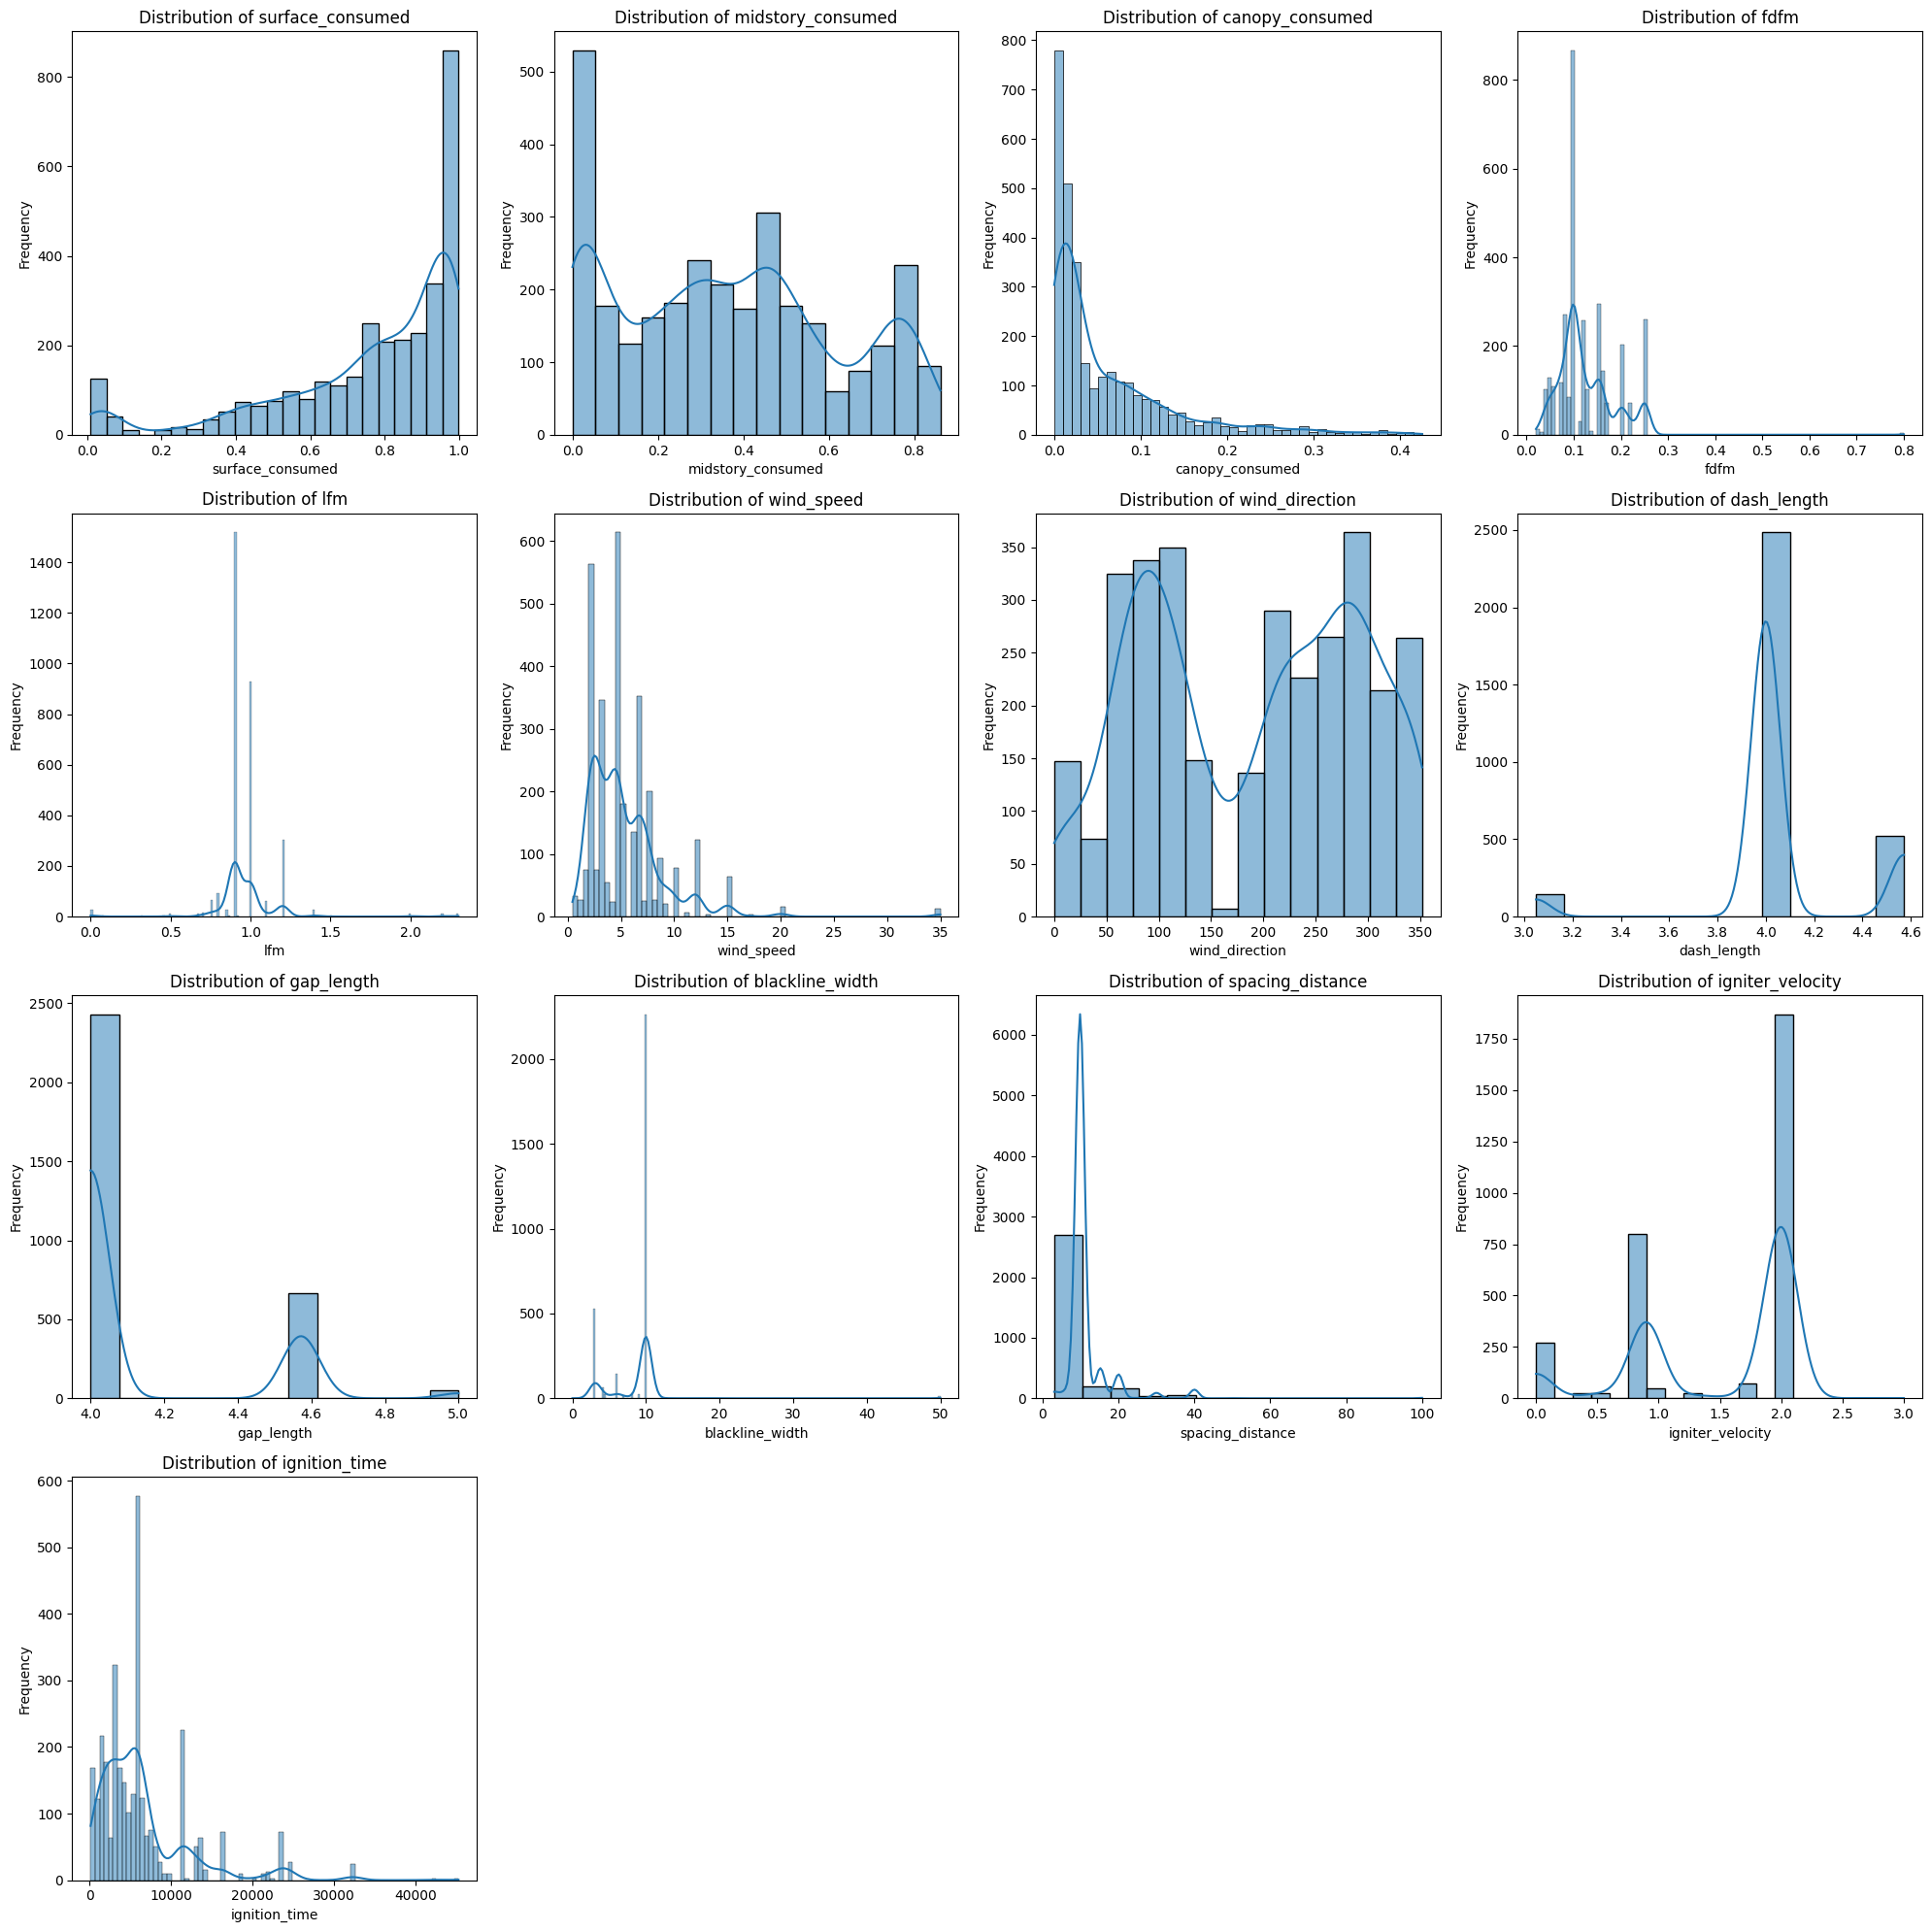

In [161]:
# Contiuous features
continuous_columns = ['surface_consumed', 'midstory_consumed', 'canopy_consumed', 'fdfm',
                     'lfm','wind_speed', 'wind_direction', 'dash_length', 'gap_length',
                     'blackline_width', 'spacing_distance', 'igniter_velocity', 'ignition_time']  

num_columns = len(continuous_columns)
rows = (num_columns + 3) // 4  # Number of rows needed for a 4-column grid

# Plot each column in the grid
plt.figure(figsize=(20, 5 * rows))
for i, col in enumerate(continuous_columns, 1):
    plt.subplot(rows, 4, i)
    sns.histplot(df[col].dropna(), kde=True)  # Drop NaN for clean distribution, add KDE for smooth curve
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

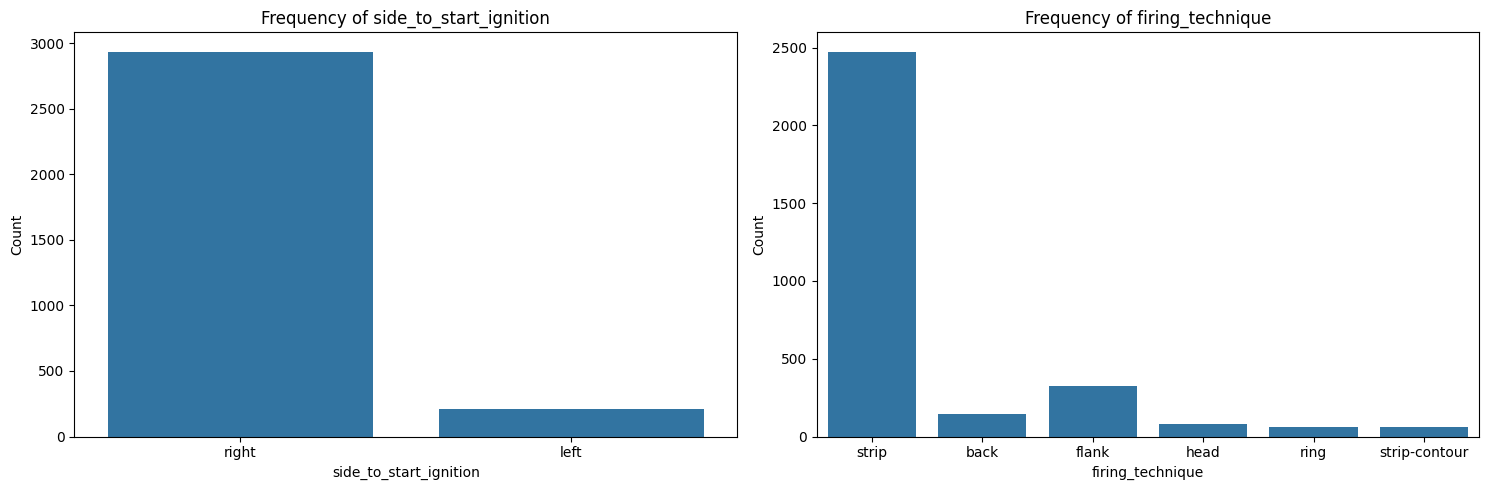

In [162]:
# Discrete features
discrete_columns = ['side_to_start_ignition', 'firing_technique' ]

num_columns = len(discrete_columns)

plt.figure(figsize=(15, 5))
for i, col in enumerate(discrete_columns, 1):
    plt.subplot(1, num_columns, i)
    sns.countplot(data=df, x=col)
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
df
df.to_csv('clean_df.csv', index=False)